# Image Handling with OpenCV

*Indiana Huey, Kobe Lin, Erin Li*

Whether you're a researcher who needs to standardize or permute a large image dataset, a photographer who needs to edit a series of photos in a specific way, or just someone with a lot of photos you'd like to alter together, this tutorial will walk you through the process of writing a script to efficiently edit a collection of photos.

Following this tutorial, you'll gain familiarity working with Python libraries including OpenCV and NumPy and with concepts including image representation and handling. Before this tutorial, we hope you're familiar with the basics of Python, such as function calls and parameters, and somewhat familiar with more advanced concepts, such as array splicing and multi-dimensional arrays. Don't worry if you haven't learned about more in-depth computer vision topics such as image color spaces and masking. We'll cover those topics!

In this tutorial, we're creating a set of profile pictures, which involves taking images of people against a white wall and placing them into images of different backgrounds. We'll also standardize the dimensions of these newly combined images so that they'll each be properly displayed when in use. As a general overview, we'll walk through the process of reading in an image of a person and an image of a background, applying changes to the images, and saving a new image in which the person has been placed in the background. Then, we'll walk through how to extend this process to iterate over multiple pairs of images.

To help us, we'll use the Python libraries OpenCV to handle and edit images, NumPy to help edit images as well, OS to grab the names of the image files, and Matplotlib to display the images in this notebook.

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

We'll also need to download the images for our project, which can be done by running the cell below. We've structured the directories such that, inside the `images` directory, there are three subdirectories, `foreground`, `background`, and `combined`, which respectively contain images of people, backgrounds, and our soon-to-be combined images of people and backgrounds.

In [ ]:
!gdown 1TjtVbDYTx4F_R90FaQXM7x_9spKDPS1v
!unzip -q images.zip -d images >/dev/null 2>&1

Downloading...
From: https://drive.google.com/uc?id=1TjtVbDYTx4F_R90FaQXM7x_9spKDPS1v
To: /content/images.zip
100% 23.7M/23.7M [00:00<00:00, 34.1MB/s]


## Reading and Cropping the Foreground

First, we'll make one profile picture from an image of a person, Indiana, and an image of a background full of balloons! After, we'll expand this process to iterate over multiple images and create all the profile pictures.

Let's read in the image of Indiana by calling the OpenCV function `imread` and giving it the path to the image. Indiana will be the foreground of the profile picture, so we'll save the image as the variable `foreground`. We can now show the image by calling the Matplotlib function `imshow` and passing it the image variable.

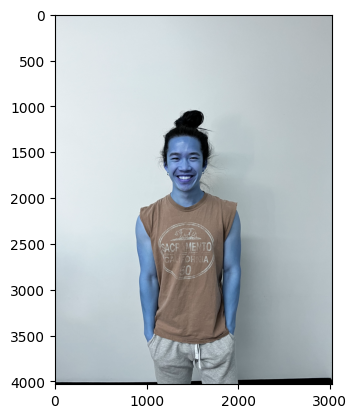

In [ ]:
foreground = cv2.imread('images/foreground/indiana.jpg')
plt.imshow(foreground)

Indiana is blue! But he's not supposed to be... This is because OpenCV reads the image in BGR format (blue, green, red), while Matplotlib shows it in RGB format (red, green, blue).

We can change the format of the image using the OpenCV function `cvtColor` and passing in as arguments the image and a pre-defined OpenCV variable `COLOR_BGR2RGB` that describes how we'd like to change the image: in this case, from BGR to RBG format.

Now when we display the image, Indiana looks normal.

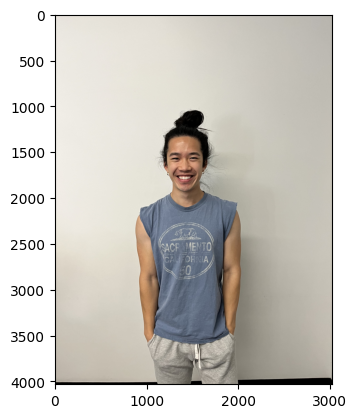

In [ ]:
rgb_foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_foreground)

Now that we've properly read in our foreground image, let's crop it to keep only the middle region of the image. In our case, we want all of our profile pictures to be 2500 by 2500 pixels, so we'll crop the image to keep just the center 2500 by 2500 square.

There might be situations in which you want to crop a different region of the image. However in this tutorial, we'll be cropping the center as most portraits (as well as our dataset specifically) usually place the person around the center.

Below we define the desired dimensions.

In [ ]:
TARGET_HEIGHT = 2500
TARGET_WIDTH = 2500

First, we need to find the center of the image, which requires us knowing the height and width of the image.

In general, images with OpenCV are represented as 3-dimensional arrays: the first dimension representing the y-plane of the image, the second representing the x-plane, and the third representing the different channels of the image. RBG images have three channels: the first containing the red values of each pixel, the second containing the green values, and the third containing the blue values. These channels change for different image formats. BGR images, for instance, have their red and blue channels switched relative to RGB images, and grayscale images only have 1 channel, simply containing the gray value of each pixel.

The image attribute `shape` contains these dimensions, returning the height, width, and number of channels of the image.

In [ ]:
height, width, channels = rgb_foreground.shape

Now we can find the center of the image by simply dividing the height and width each by 2, remembering to use integer division as we want the locations of discretely positioned pixels. (You can't index half a pixel!)

In [ ]:
center_height = height // 2
center_width = width // 2

We then use these center coordinates to find the leftmost and rightmost coordinates of the region we'd like to keep by respectively moving left and right away from the center point by one half of the target width, as moving away in both directions by one half of the target width leaves the full target width between these points.

We then use this same logic to find the topmost and bottommost coordinates, moving up and down by one half of the target height.

In [ ]:
left_width = center_width - (TARGET_WIDTH // 2)
right_width = center_width + (TARGET_WIDTH // 2)

top_height = center_height - (TARGET_HEIGHT // 2)
bottom_height = center_height + (TARGET_HEIGHT // 2)

Now that we have leftmost, rightmost, topmost, and bottommost coordinates of the region we'd like to keep, we can crop the image by grabbing just the pixels between these coordinates, using array splicing in both the y- and x-dimensions, and storing them in a variable `cropped_foreground`.

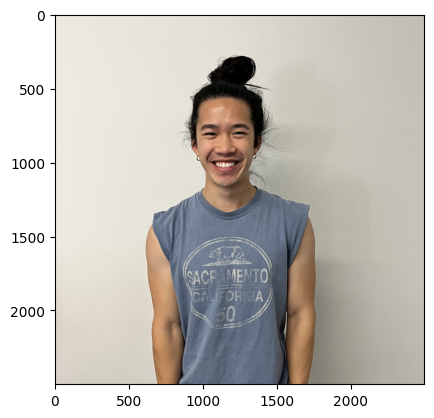

In [ ]:
cropped_foreground = rgb_foreground[top_height : bottom_height, left_width : right_width]
plt.imshow(cropped_foreground)

## Reading, Resizing, and Cropping the Background

Great! Now, let's read in the background image.

As discussed before, the `imread` function reads images in BGR format. As such, let's also convert the background image to be in RGB format.

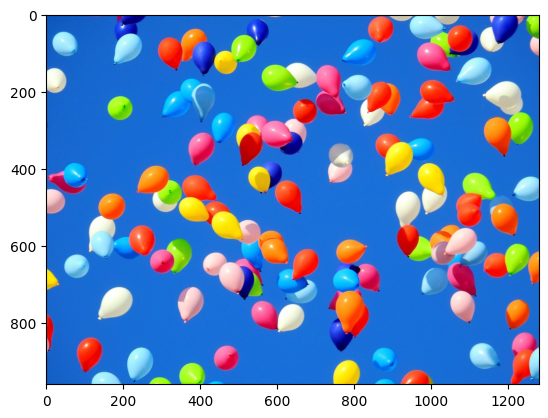

In [ ]:
background = cv2.imread('images/background/indiana.jpg')
rbg_background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
plt.imshow(rbg_background)

Now, let's resize our background image. We didn't do this for our foreground image as we chose a `TARGET_HEIGHT` and `TARGET_WIDTH` that are smaller than the dimensions of our foreground images, so we can just crop them. However, some of the background images might not be large enough to fit the target height and width, so we need to resize them before cropping them to the target height and width.

We find out how much we need to resize our image by taking the ratio between the target height and width with the actual height and width of our background image. Then, whichever ratio is larger is the ratio by which we need to scale our image to be at least the target height and width.

Again, we use the image attribute `shape` to get the actual height and width of the background image.

In [ ]:
height, width, channels = rbg_background.shape

height_ratio = TARGET_HEIGHT / height
width_ratio = TARGET_WIDTH / width

scale_ratio = height_ratio if (height_ratio > width_ratio) else width_ratio

Now that we have the scaling ratio, we can resize our image with the OpenCV function `resize`.

This function takes in four parameters:
1. `image` = the image to resize
2. `dimensions` = the target dimensions to which to scale the image
3. `fx` = the ratio by which to scale the x-dimension of the image
4. `fy` = The ratio by which to scale the y-dimension of the image

As we've calculated the ratio by which to scale the x- and y-dimensions, we can pass this ratio in for both `fx` and `fy`. Then, as we're using this ratio to scale, we don't need to specify the dimensions to which to scale, so we set the `dimensions` parameter to `None`.

Using the `dimensions` parameter, we could simply resize the image to be exactly the target height and width. However, this could result in the image becoming stretched or squashed. So, we calculate and use the scaling ratio so that the ratio between the height and width of the image remains the same after being resized and no stretching or squashing occurs.

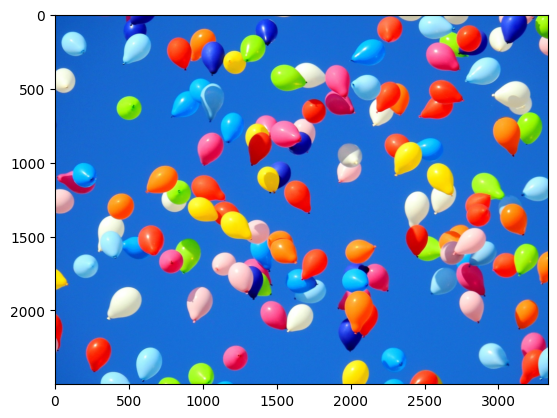

In [ ]:
resized_background = cv2.resize(rbg_background, None, fx = scale_ratio, fy = scale_ratio)
plt.imshow(resized_background)

Nice! Now that we've properly scaled our background image, we can crop it to fit the target height and width. The logic for how to do this is the same as how we cropped the foreground image, so the code is very similar.

We get the dimensions of the image with the `shape` attribute, find the center of the image, find the outer points of the target region around the center, and keep only the pixels between these outer points.

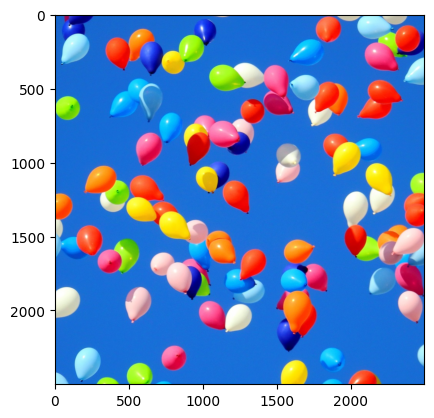

In [ ]:
height, width, channels = resized_background.shape

center_height = height // 2
center_width = width // 2

top_height = center_height - (TARGET_HEIGHT // 2)
bottom_height = center_height + (TARGET_HEIGHT // 2)

left_width = center_width - (TARGET_WIDTH // 2)
right_width = center_width + (TARGET_WIDTH // 2)

cropped_background = resized_background[top_height : bottom_height, left_width : right_width]
plt.imshow(cropped_background)

## Creating a Binary Mask from the Foreground

The foreground and background images are now the same shape and size! This makes adding them easy!

So what is a binary mask? It is an image that is represented in a 2-dimensional array of only `0`s and `1`s. When we apply a binary mask to an image, it will only keep the areas of the image which intersect with the `1`s in the binary mask while all the other areas will become `0`s. Binary masks will help us isolate the foreground and the background.

Before we create a binary mask, let's try simply adding the foreground image and the background image and see why binary mask is necessary.

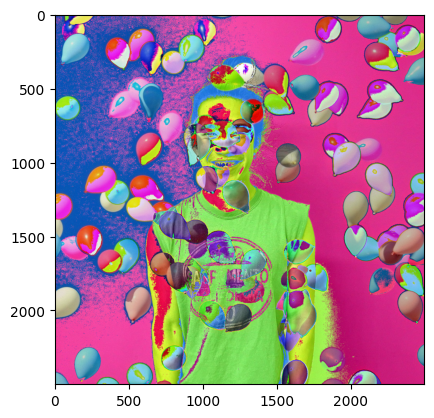

In [ ]:
questionably_combined_image = cropped_foreground + cropped_background
plt.imshow(questionably_combined_image)

What's going on? The red, green, and blue values from the foreground and background are literally being added. For instance, if a pixel in the foreground image has a red value of 50 and the pixel in the same location in the background image has as red value of 25, then the pixel in that location in the combined image will have a red value of 75.

What we actually want is for that pixel in the combined image to have a value of 50 if it's a pixel from Indiana or a value of 25 if a pixel from the birthday party _around_ Indiana. To do this, we'll zero-out the pixel values in the foreground image that aren't Indiana---i.e. pixels of the white wall---and zero-out pixels values in the background image that are where Indiana will be placed. Then, adding these modified images together will be like putting two puzzle pieces together without any unwanted overlap.

To zero-out the appropriate pixels, let's make a binary mask.

We can initialize this mask as just all 1s and then filter out---i.e. set to 0---the pixels that don't fit our criteria.

We initialize it as a NumPy array of 1s with `np.ones`, passing it a tuple of the height and width we want the array to be, in this case, the same height and width as the images to which it will be applied.

In [ ]:
mask = np.ones((TARGET_HEIGHT, TARGET_WIDTH))

Now, let's set pixels in the mask that correspond to locations that Indiana occupies in the foreground image to 0. Or, in other words, we only want to keep the 1s in the mask that correspond to the white wall.

We want to think of an effective way to determine if a pixel belongs the white wall or Indiana. Describing a white wall is definitely easier than Indiana... as a white wall is mostly just white. However, a white wall isn't often perfectly white, in fact. There are shadows and some gray tones, which makes it difficult to think about which values of red, green, and blue combine to make up the colors of the wall. Other image formats, however, are more intuitive for capturing specific color tones---specifically, HSV, denoting hue, saturation, and value channels.

* `Hue` refers to the dominant pure color of the image in the full color spectrum, which ranges from 0 to 360.
* `Saturation` refers to the intensity or purity of the color, which ranges from 0 to 100. 100 being the purest or the most intense. More intuitively, colors with lower satuaration are more grey-ish.
* `Value` refers to the brightness or darkness of the color, which ranges from 0 to 100. 0 being the darkest/black and 100 being the brightest/white.

Let's convert the forerground to HSV.

In [ ]:
hsv_foreground = cv2.cvtColor(cropped_foreground, cv2.COLOR_RGB2HSV)

Now, we can think about what values of hue, saturation, and value might characterize a white wall. Some white walls are slightly blue, or orange, or yellow, depending on the paint and lighting, making hue not very effective at describing white walls generally. Saturation, however, is good at describing white walls as white and gray are characterized by being very low in saturation. Additionally, the wall, while lacking in color, is specifically closer to white than it is to black, meaning that it has relatively higher values in the value channel.

This means that we can guess that a pixel belongs to the white wall if its saturation is _below_ a certain threshold and its value is _above_ another threshold. In this case, we found that a saturation threshold of 40 and a value threshold of 100 effectively describes pixels of our white wall.

__Note:__ The thresholds could be different in different cases depending on many different factors, so feel free to trial and error and see what values of the thresholds work the best for your case.

In [ ]:
saturation_channel = 1
value_channel = 2
saturation_threshold = 40
value_threshold = 100

We can then apply a logical `and` between our mask and the foreground image with these threshold, such that a pixel in the mask remains as a 1 only if its corresponding pixel in the foreground image has a saturation lower than the threshold and a value higher than the threshold.

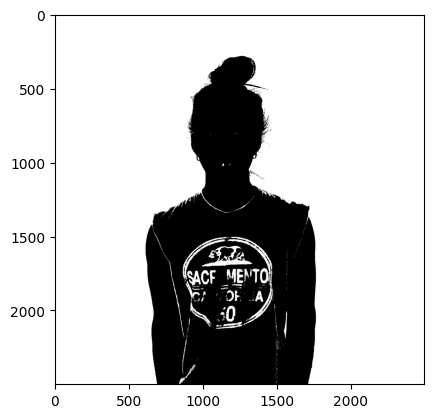

In [ ]:
mask = np.logical_and(mask, hsv_foreground[:, :, saturation_channel] < saturation_threshold)
mask = np.logical_and(mask, hsv_foreground[:, :, value_channel] > value_threshold)

plt.imshow(mask, cmap = 'gray')

## Improving the Mask using Connected Components

We've got a binary mask to separate the foreground from the white wall, but it seems that the mask needs some more work. Unfortunately, parts of Indiana's cloth and teeth aren't properly filtered out and are included as part of the background because they share similar colors with the white wall. We do not want this to happen because when we later combine the foreground and the background, this would make Indiana's cloth and teeth to be filled with the background image.

Our solution to this problem is to find the largest connected component in our mask. In a binary mask, a connected component would be a set of white pixels that are connected to each other, forming a single connected region. In our case, we expect the largest component to be the white wall, as it is likely to have the largest area compared to other smaller components like Indiana's cloth and teeth. If we can identify the largest component, then we can mark every pixel that does not belong to the largest component as `0`, which would improve the quality of our binary mask.

This can be done using the function `connectedComponentsWithStats`.

`connectedComponentsWithStats` returns 4 values:
* count
* labels
* stats
* centroids

`count` is us the total number of connected components.

`labels` is a mask that has the same dimension as our foreground image. Each pixel in the mask is labeled with an ID that corresponds to the component it belongs. The background pixels are labeled with 0, and the connected components are labeled with consecutive integers starting from 1.

`stats` is an array that contains some statistics on each connected component, including the area (in pixel).

`centroids` is an array that contains the center (x,y) coordinate of each component.

In [ ]:
count, labels, stats, centroids = cv2.connectedComponentsWithStats(mask.astype('uint8'))

Now that we have these values, we want to find the connected component that has the largest area.

We first sort the components by their areas in ascending order. We can slice the `stats` array to extract the area values for all the connected components. Notice that `cv2.CC_STAT_AREA` is a constant that represents the index of the area statistic in the `stats` array. Then we can sort the areas using the function `argsort`. It returns an array of indices that would sort the areas in ascending order, and we store this array to `sorted_labels`.

To get the label for the largest connected component, we just index to -1, and we store this label to the variable `biggest_label`.

In [ ]:
sorted_labels = stats[:, cv2.CC_STAT_AREA].argsort()
biggest_label = sorted_labels[-1]

Now that we have the label for the largest connected component, we want to mark all pixels that have the same label with the largest connected component as `1`s and mark all other pixels as `0`s. This create our background mask.

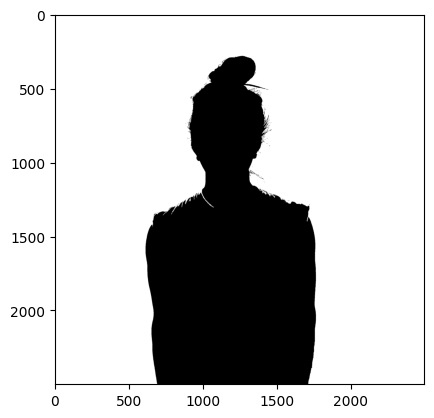

In [ ]:
labels[labels != biggest_label] = 0
labels[labels == biggest_label] = 1

background_mask = labels
plt.imshow(background_mask, cmap = 'gray')

As we can see, Indiana's clothes and teeth are now all filtered out.

We could obtain the foreground mask by using the logical not on the background mask.

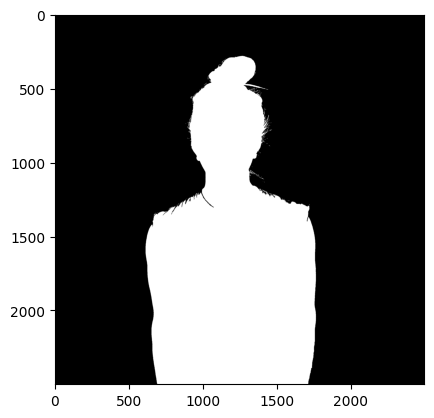

In [ ]:
foreground_mask = np.logical_not(background_mask)
plt.imshow(foreground_mask, cmap = 'gray')

Congratulations! You are now done with the most difficult part of this tutorial.

## Applying the Masks to the Foreground and Background

Now, we want to apply our masks to the foreground and background. First, let's convert the background to HSV so that it's in the same format as the foreground with which it will eventually be combined.

In [ ]:
hsv_background = cv2.cvtColor(cropped_background, cv2.COLOR_RGB2HSV)
_, _, channels = hsv_background.shape

In order to apply our masks, we are going to multiply the channel values of each image with their respective masks. If you recall, the masks we made are binary masks, where the parts we want to keep have a value of 1, and the parts we don't want to keep have a value of 0. As such, by multiplying an image with its respective mask, we are in essence deleting or zeroing-out the parts of the image we don't want.

The reason we need to do this is because when we combine the foreground and background images together later, we need to be sure there aren't any pairs of non-zero valued pixels that overlap; otherwise, the channel values of those pixels will be combined and be higher than we intend.

<Figure size 640x480 with 0 Axes>

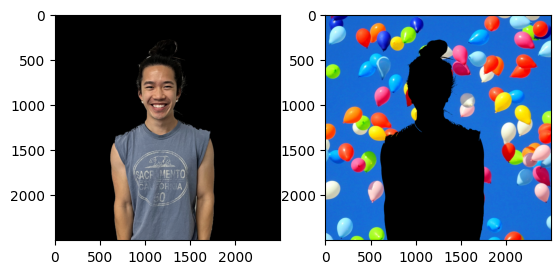

In [ ]:
for channel in range(channels):
    hsv_background[:, :, channel] = hsv_background[:, :, channel] * background_mask
    hsv_foreground[:, :, channel] = hsv_foreground[:, :, channel] * foreground_mask

# show both images in RGB format
fig = plt.figure()
_, plots = plt.subplots(1, 2)
plots[0].imshow(cv2.cvtColor(hsv_foreground, cv2.COLOR_HSV2RGB))
plots[1].imshow(cv2.cvtColor(hsv_background, cv2.COLOR_HSV2RGB))

## Combining the Foreground and Background

As you can see, we've essentially made "puzzle pieces" out of our foreground and background images that we can combine together!

Now that we have these images, we can simply combine them by adding them together! After we do this, we can convert the combined image from HSV to RGB so that it looks normal when displayed.

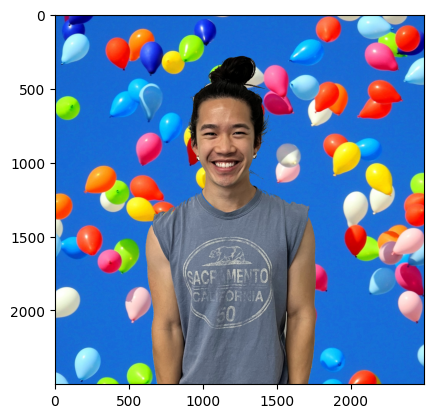

In [ ]:
combined = hsv_foreground + hsv_background
rgb_combined = cv2.cvtColor(combined, cv2.COLOR_HSV2RGB)
plt.imshow(rgb_combined)

We can then save our combined image using the `cv2.imwrite` function, passing it the file path and name of our combined image and the image variable itself. In the same way OpenCV reads images in as BGR, however, it writes images out from BGR, so we must first convert it to BGR.

In [ ]:
bgr_combined = cv2.cvtColor(combined, cv2.COLOR_HSV2BGR)
cv2.imwrite('images/combined/indiana.jpg', bgr_combined)

True

## Iterating over Multiple Images

You are now able to combine a foreground image with a background image. Now let's explore how to repeat the same process for multiple foreground images along with their corresponding background images.

We have stored all of our foreground images in the directory `images/foreground/`. We can print the list of files in the directory.

In [ ]:
path = 'images/foreground/'
os.listdir(path)

['indiana.jpg', 'erin.jpg', 'kobe.jpg']

Let's save the list of image file names as a variable `image_names`.

In [ ]:
image_names = os.listdir('images/foreground/')
image_names

['indiana.jpg', 'erin.jpg', 'kobe.jpg']

From here, let's write some helper functions that will be useful to us. We should make a helper function for each of the four major topics we learned throughout the tutorial: cropping an image, resizing an image, creating a mask, and creating a masked image.

For each of these functions, there isn't anything you haven't seen before! We are simply re-writing and compiling the code we've written thus far into functions that we can call.

Let's first start with writing the function ```cropped_image()```. For this function, we should pass in the image we want to crop, and the target height and width of the image after we crop.

From here, we can follow the same process we learned earlier in the tutorial, where we find the center of the image, and crop around it, essentially making a box with that has the target height and width.

In [ ]:
def cropped_image(image, target_height, target_width):

    # We grab the height and width of the image, then find the center
    height, width, _ = image.shape

    center_height = height // 2
    center_width = width // 2

    top_height = center_height - (target_height // 2)
    bottom_height = center_height + (target_height // 2)

    left_width = center_width - (target_width // 2)
    right_width = center_width + (target_width // 2)

    # By using array splicing, we are able to crop for the specific dimensions we want
    crop = image[top_height : bottom_height, left_width : right_width]

    return crop

Now, let's write the function ```resize_image()```. For this function, we again need to pass in the image we want to resize, and we need the dimensions we are resizing the image to. From here, just like for ```cropped_image()```, we can resize the image like we did previously in the tutorial.

In [ ]:
def resized_image(image, target_height, target_width):

    # We grab the height and width of the image, then find which dimension
    # has the larger ratio from their target values
    height, width, _ = image.shape

    height_ratio = target_height / height
    width_ratio = target_width / width

    # We set the scale ratio to the larger of the two, then use the OpenCV
    # resize() function to resize the image
    scale_ratio = height_ratio if (height_ratio > width_ratio) else width_ratio

    resized = cv2.resize(image, None, fx=scale_ratio, fy=scale_ratio)

    return resized

From here, we should write a function called ```create_masks()```. This function will, just like the previous two functions, take in the image we want to create a mask for. From here, we will pass in the desired `saturation_threshold` and `value_threshold` for creating the mask.

In [ ]:
def create_masks(image, saturation_threshold, value_threshold):

    # We want to make an HSV image
    # This helps us to grab the white of the background easier
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # We make a mask of all 1s with the dimension of our image
    height, width, _ = image.shape
    mask = np.ones((height, width))

    # We look for pixels of the image below our saturation_threshold and above our
    # value_threshold. These pixels are likely to be the pixels of the wall.
    saturation_channel = 1
    value_channel = 2
    mask = np.logical_and(mask, hsv_image[:, :, saturation_channel] < saturation_threshold)
    mask = np.logical_and(mask, hsv_image[:, :, value_channel] > value_threshold)

    # We use connected components to find the largest "blob" (the wall), and label all
    # pixels that are part of the wall with a 1
    _, labels, stats, _ = cv2.connectedComponentsWithStats(mask.astype('uint8'))
    sorted_labels = stats[:, cv2.CC_STAT_AREA].argsort()
    biggest_label = sorted_labels[-1]

    labels[labels != biggest_label] = 0
    labels[labels == biggest_label] = 1

    # We create our foreground mask by reversing our background mask
    background_mask = labels
    foreground_mask = np.logical_not(background_mask)

    return background_mask, foreground_mask

Lastly, we need to write a function ```masked_image()```. This function will take in an image and a mask, and creates a masked image. We combine the mask and the image by multiplying their channels together. This works because the parts that we want are denoted as 1s in our mask and the parts we don't want are denoted by 0s. Thus, the parts of the image we want are kept, and the parts we don't want are essentially deleted.

In [ ]:
def masked_image(image, mask):
    _, _, channels = image.shape

    masked = image.copy()

    for channel in range(channels):
        masked[:, :, channel] = masked[:, :, channel] * mask

    return masked

We now have all the functions that we need! We can now use these to create a ```combine_images()``` function. This function condenses all the code and concepts that we wrote step by step in this tutorial, and combines a foreground and background image into one.

In [ ]:
def combine_images(foreground_image_path, background_image_path, combined_image_path, target_height, target_width):
    foreground = cv2.imread(foreground_image_path)
    background = cv2.imread(background_image_path)

    cropped_foreground = cropped_image(foreground, target_height, target_width)

    resized_background = resized_image(background, target_height, target_width)
    cropped_background = cropped_image(resized_background, target_height, target_width)

    background_mask, foreground_mask = create_masks(cropped_foreground, saturation_threshold, value_threshold)

    masked_foreground = masked_image(cropped_foreground, foreground_mask)
    masked_background = masked_image(cropped_background, background_mask)

    combined_image = masked_foreground + masked_background

    # This OpenCV imwrite() function allows us to save the combined image we create
    # to a specific file path.
    cv2.imwrite(combined_image_path, combined_image)

To repeat the process over all the foreground and background images, we iterate over each image name in `image_names` with a for loop.

An important thing to notice is that we have used exactly the same file names for foreground images and background images and stored them in their corresponding folders. This naming convention allows us to easily traverse through all the file names and combine foreground images and background images with matching file name.

In [ ]:
for image_name in image_names:
    # we set the paths by adding the image name to the end of where we know these images are located
    foreground_image_path = 'images/foreground/' + image_name
    background_image_path = 'images/background/' + image_name
    combined_image_path = 'images/combined/' + image_name

    # ignore non-image files like .DS_Store
    if image_name[0] != '.':
        combine_images(foreground_image_path, background_image_path, combined_image_path, target_height=2500, target_width=2500)

And that was the last step! Let's take a look at the results we have.

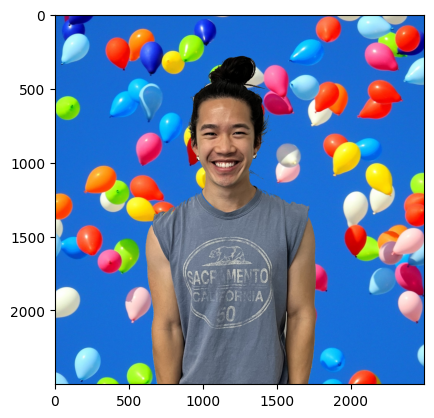

In [ ]:
profile1 = cv2.imread('images/combined/indiana.jpg')
profile1 = cv2.cvtColor(profile1, cv2.COLOR_BGR2RGB)
plt.imshow(profile1)

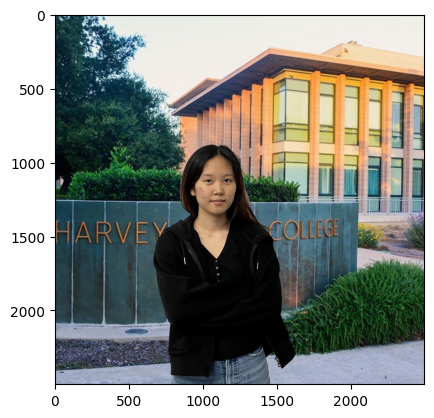

In [ ]:
profile2 = cv2.imread('images/combined/erin.jpg')
profile2 = cv2.cvtColor(profile2, cv2.COLOR_BGR2RGB)
plt.imshow(profile2)

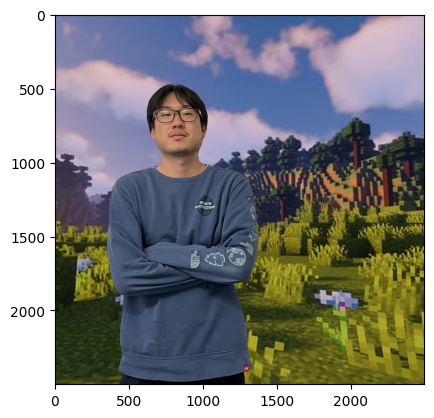

In [ ]:
profile3 = cv2.imread('images/combined/kobe.jpg')
profile3 = cv2.cvtColor(profile3, cv2.COLOR_BGR2RGB)
plt.imshow(profile3)

That looks awesome! We have now learned how to use OpenCV to make transformations and changes to images. Specifically, we were able to grab two images (a foreground and a background), and combine them into one singular image. From here, we were also able to apply this combination to a larger set of images, automating this process for all those images!